# Feature Engineering with Latent Dirichlet Allocation Topic Modelling

In [1]:
import numpy as np
import pandas as pd

In [2]:
import string
import re

In [3]:
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from pprint import pprint
import tqdm

In [4]:
df = pd.read_csv('raw_data.txt')

In [5]:
df.head()

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text
0,2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....,A meeting of the Federal Open Market Committe...
1,2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...
2,2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...
3,2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...
4,2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...


In [6]:
df.dropna(subset=['text'], inplace=True)

In [7]:
df = df.iloc[1:,:]

### Text Preprocessing

#### Functions to remove of punctuation, make lowercase and strip, remove integer, tokenise words, lemmatise words, remove stopwords

In [8]:
def clean_text(sentence):
    """
    Description: Main method for cleaning text by removing punctuations, integers, whitespaces and making lowercase

    Input:
    * String: The string to be preprocessed.

    Return:
    * String: The cleaned string.
    """
    
    
    def replace_punctuation(sentence):
        """
        Description: Replaces punctuation in string with space.

        Input:
        * String: The string to be preprocessed.

        Return:
        * String: The string with punctuation replaced with space.
        """
        return sentence.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

    def make_lower_and_strip(sentence):
        """
        Description: Strip string and make lowercase.

        Input:
        * String: The string to be preprocessed.

        Return:
        * String: The string stripped and made lowercase.
        """
        return re.sub(r'[^\w\s]', '', sentence.lower().strip())

    def remove_integer(sentence):
        """
        Description: Removes integers in string.

        Input:
        * String: The string to be preprocessed.

        Return:
        * String: The string with integers removed.
        """
        return re.sub(r'[0-9]+', '', sentence)
    
    try:
        return replace_punctuation(make_lower_and_strip(remove_integer(sentence)))
    except:
        return None

In [9]:
def tokenize(sentence):
    """
    Description: Tokenizes sentence into list of words.

    Input:
    * String: The string to be tokenized.

    Return:
    * List: The list of words in the sentence.
    """
    try:
        word_list = sentence.split()
        return word_list
    except:
        return None

In [10]:
def remove_stopwords(word_list, stopwords=None):
    """
    Description: Removes stopwords and words with length less than 4.

    Input:
    * List: The list of words to be preprocessed.

    Return:
    * List: The list of words with stopwords and words with length less than 4 removed.
    """
    try:
        if stopwords is not None:
            return [word for word in word_list if ((word not in stopwords) and len(word) > 3)]
        else:
            return [word for word in word_list if len(word) > 3]
    except:
        return None

#### Clean text and tokenise

In [11]:
df['cleaned'] = df.text.apply(lambda x: clean_text(x))
df['cleaned_token'] = df.cleaned.apply(lambda x: tokenize(x))
#df['cleaned_token_lemm'] = df.cleaned_token.apply(lambda x: lemmatize(x))

#### Using NLTK stopwords

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [13]:
df['cleaned_tokenized_nostop'] = df.cleaned_token.apply(lambda x: remove_stopwords(x, stop_words))

In [14]:
df.head()

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text,cleaned,cleaned_token,cleaned_tokenized_nostop
1,2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."
2,2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...,i am pleased to participate in the panel discu...,"[i, am, pleased, to, participate, in, the, pan...","[pleased, participate, panel, discussion, inst..."
3,2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."
4,2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."
5,2006-06-30,NaN,NaN,15302.705,201.8,4.6,136325.0,177343.0,8420042.0,16.779000,4.991000,NaN,Good morning. And if you will indulge me on t...,NaN,"Chairman Bachus, Representative Sanders and m...",NaN,Good morning. And if you will indulge me on t...,good morning and if you will indulge me on thi...,"[good, morning, and, if, you, will, indulge, m...","[good, morning, indulge, national, holiday, wo..."


#### Make Bigrams

In [15]:
data_words = df.cleaned_token.tolist()

In [16]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [18]:
data_words_nostops = df.cleaned_tokenized_nostop.tolist()
data_words_bigrams = make_bigrams(data_words_nostops)

#### Lemmatise

In [19]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [21]:
df['data_lemmatized'] = data_lemmatized

In [22]:
df.head()

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,...,minutes,speeches,statements,testimony,pressconf,text,cleaned,cleaned_token,cleaned_tokenized_nostop,data_lemmatized
1,2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,...,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,..."
2,2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,...,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...,i am pleased to participate in the panel discu...,"[i, am, pleased, to, participate, in, the, pan...","[pleased, participate, panel, discussion, inst...","[please, participate, panel, discussion, insti..."
3,2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,...,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,..."
4,2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,...,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,..."
5,2006-06-30,NaN,NaN,15302.705,201.8,4.6,136325.0,177343.0,8420042.0,16.779000,...,NaN,Good morning. And if you will indulge me on t...,NaN,"Chairman Bachus, Representative Sanders and m...",NaN,Good morning. And if you will indulge me on t...,good morning and if you will indulge me on thi...,"[good, morning, and, if, you, will, indulge, m...","[good, morning, indulge, national, holiday, wo...","[good, morning, indulge, national, holiday, wi..."


#### Preprocessed vs Processed

In [23]:
df.iloc[:,[-5,-2,-1]]

,text,cleaned_tokenized_nostop,data_lemmatized
1,A meeting of the Federal Open Market Committe...,"[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,..."
2,I am pleased to participate in the panel disc...,"[pleased, participate, panel, discussion, inst...","[please, participate, panel, discussion, insti..."
3,A meeting of the Federal Open Market Committe...,"[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,..."
4,A meeting of the Federal Open Market Committe...,"[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,..."
5,Good morning. And if you will indulge me on t...,"[good, morning, indulge, national, holiday, wo...","[good, morning, indulge, national, holiday, wi..."
...,...,...,...
177,"November 4-5, 2020A joint meeting of the Fede...","[november, joint, meeting, federal, open, mark...","[november, joint, meeting, federal, open, mark..."
178,"December 15-16, 2020\nA joint meeting of the ...","[december, joint, meeting, federal, open, mark...","[december, joint, meeting, federal, open, mark..."
179,"January 26-27, 2021A joint meeting of the Fed...","[january, joint, meeting, federal, open, marke...","[january, joint, meeting, federal, open, marke..."
180,Today I will discuss the state of our labor m...,"[today, discuss, state, labor, market, recent,...","[today, discuss, state, labor, market, recent,..."


### LDA Topic Modelling

#### Train Test Split

In [24]:
X = df.data_lemmatized.values

In [25]:
train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 181
Training Observations: 126
Testing Observations: 55


#### Data transformation for LDA topic model inputs

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(train)
# Create Corpus
texts = train
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 26), (6, 21), (7, 1), (8, 15), (9, 2), (10, 5), (11, 2), (12, 1), (13, 4), (14, 14), (15, 1), (16, 1), (17, 2), (18, 13), (19, 9), (20, 6), (21, 4), (22, 5), (23, 1), (24, 4), (25, 2), (26, 4), (27, 8), (28, 1), (29, 1), (30, 2), (31, 3), (32, 3), (33, 55), (34, 1), (35, 1), (36, 26), (37, 1), (38, 1), (39, 3), (40, 2), (41, 1), (42, 1), (43, 5), (44, 1), (45, 7), (46, 1), (47, 1), (48, 3), (49, 1), (50, 14), (51, 12), (52, 5), (53, 1), (54, 77), (55, 1), (56, 1), (57, 5), (58, 4), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 119), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 8), (73, 29), (74, 1), (75, 3), (76, 17), (77, 33), (78, 35), (79, 1), (80, 18), (81, 6), (82, 1), (83, 1), (84, 1), (85, 3), (86, 11), (87, 1), (88, 16), (89, 1), (90, 1), (91, 1), (92, 3), (93, 2), (94, 1), (95, 11), (96, 1), (97, 14), (98, 1), (99, 5), (100, 8), (101, 2), (102, 1), (103, 7), (104, 1), (105, 3), (106, 2), (107, 1), (108, 7

#### Building baseline LDA model

##### Using default alpha and eta parameters with num_topics=10
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter eta: Word-Topic Density

In [27]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [28]:
pprint(lda_model.print_topics())

[(0,
  '0.014*"market" + 0.013*"rate" + 0.013*"think" + 0.008*"policy" + '
  '0.007*"chairman" + 0.006*"federal" + 0.006*"financial" + 0.006*"fund" + '
  '0.006*"purchase" + 0.005*"go"'),
 (1,
  '0.007*"market" + 0.005*"rate" + 0.004*"think" + 0.004*"inflation" + '
  '0.003*"percent" + 0.003*"financial" + 0.003*"bank" + 0.003*"price" + '
  '0.003*"time" + 0.003*"federal"'),
 (2,
  '0.012*"think" + 0.010*"rate" + 0.009*"policy" + 0.009*"chairman" + '
  '0.008*"market" + 0.007*"inflation" + 0.006*"year" + 0.006*"economic" + '
  '0.005*"financial" + 0.005*"go"'),
 (3,
  '0.013*"inflation" + 0.010*"think" + 0.009*"market" + 0.008*"growth" + '
  '0.007*"rate" + 0.007*"price" + 0.007*"policy" + 0.006*"chairman" + '
  '0.006*"year" + 0.006*"forecast"'),
 (4,
  '0.017*"financial" + 0.013*"reserve" + 0.013*"bank" + 0.012*"federal" + '
  '0.011*"market" + 0.008*"credit" + 0.007*"firm" + 0.006*"loan" + '
  '0.006*"policy" + 0.006*"institution"'),
 (5,
  '0.014*"market" + 0.012*"inflation" + 0.010

##### Using c_v Coherence Score to evaluate LDA topic model performance
- C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [29]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nBaseline Coherence Score: ', coherence_lda)


Baseline Coherence Score:  0.288416780696753


In [30]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           workers=3, # set to number of cores - 1
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=texts, 
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

#### Hyperparameter Tuning

In [31]:
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

##### Topics range

In [32]:
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

##### Alpha range

In [33]:
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

##### Eta range

In [34]:
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

##### Grid search

In [35]:
if 1 == 1:
    pbar = tqdm.tqdm(total=270)
    
    for k in topics_range:
        for a in alpha:
            for b in eta:
                cv = compute_coherence_values(corpus=corpus, 
                                              dictionary=id2word, 
                                              k=k, 
                                              a=a, 
                                              b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)

                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [5:29:24<00:00, 73.20s/it]


#### Grid search result

In [36]:
result = pd.read_csv('lda_tuning_results.csv').sort_values(by=['Coherence'],ascending=False)

In [37]:
result.head()

,Topics,Alpha,Eta,Coherence
124,6,0.01,symmetric,0.324165
129,6,0.31,symmetric,0.324165
134,6,0.61,symmetric,0.324165
139,6,0.9099999999999999,symmetric,0.324165
144,6,symmetric,symmetric,0.324165


#### Building final LDA model

##### Defining model parameters

In [45]:
k = 6
a = 0.01
b = 'symmetric'

In [46]:
# Create Dictionary
id2word = corpora.Dictionary(X)
# Create Corpus
texts = X
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [47]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       workers=3,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)

##### Visualise topics

In [50]:
import pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

C:\Users\jorda\anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\jorda\anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.003935 -0.037821       1        1  39.459423
3      0.054584  0.041412       2        1  21.540583
5      0.006175 -0.020423       3        1  18.365012
1      0.008843 -0.008500       4        1  17.705293
4     -0.008026 -0.004362       5        1   2.929643
0     -0.065513  0.029694       6        1   0.000046, topic_info=           Term          Freq         Total Category  logprob  loglift
2574     market  40865.000000  40865.000000  Default  30.0000  30.0000
3459       rate  41617.000000  41617.000000  Default  29.0000  29.0000
4327      think  33754.000000  33754.000000  Default  28.0000  28.0000
3192     policy  30348.000000  30348.000000  Default  27.0000  27.0000
1618    federal  22695.000000  22695.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
893    continue      0.004790  15758.159593   Topic6  -5.9420  -0.4197
4359       time      0.004835  16873.064434   Topic6  -5.9328  -0.4788
2168  inflation      0.005902  34648.182896   Topic6  -5.7333  -0.9988
372        bank      0.005366  25055.304995   Topic6  -5.8285  -0.7699
4794       year      0.004940  21969.543825   Topic6  -5.9113  -0.7212

[602 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
18254      1  0.024755  aaarate
18254      2  0.024755  aaarate
18254      3  0.074265  aaarate
18254      4  0.841666  aaarate
18254      5  0.024755  aaarate
...      ...       ...      ...
4794       2  0.175243     year
4794       3  0.185439     year
4794       4  0.147568     year
4794       5  0.023032     year
20929      5  0.410526    yunus

[1336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 2, 5, 1])

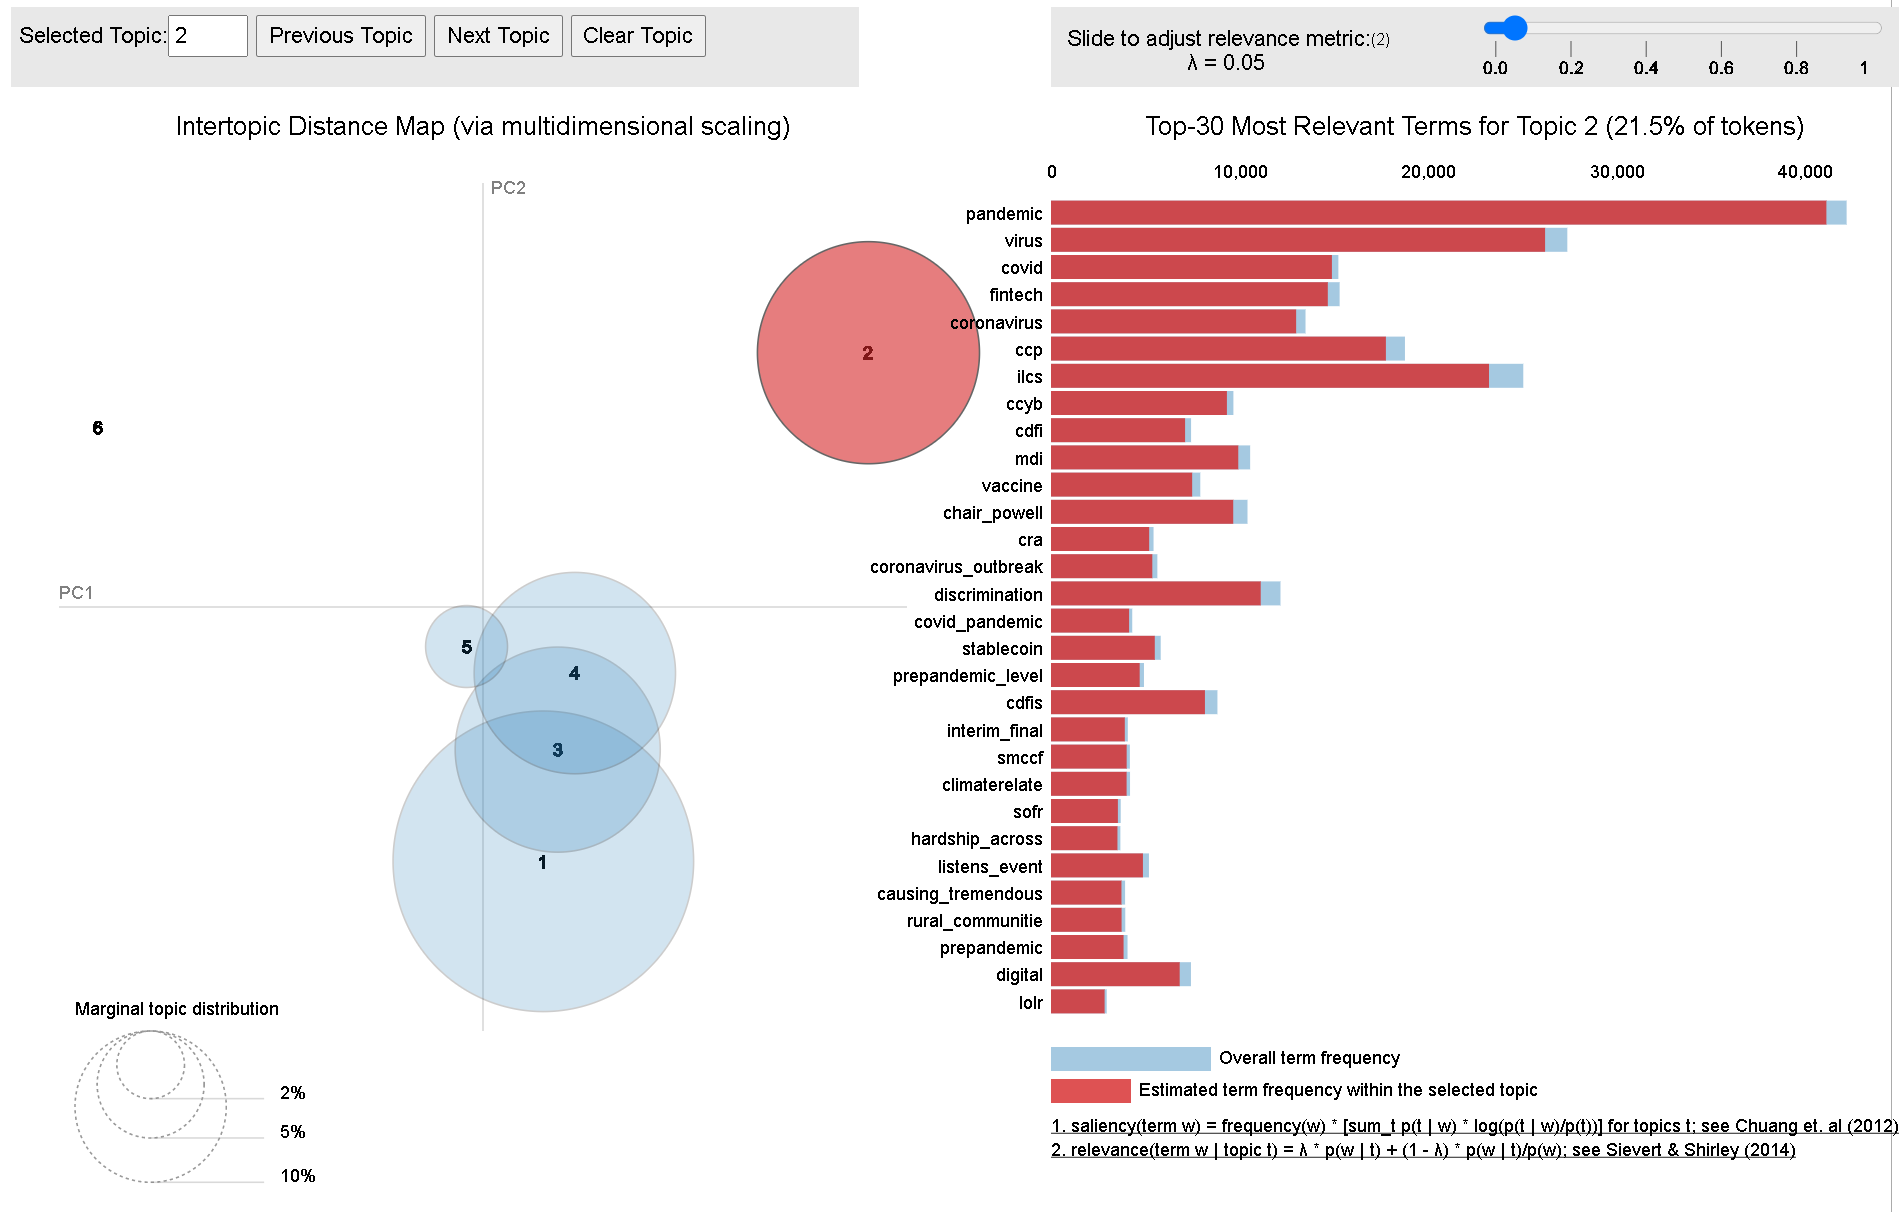
Topic 2 is about COVID-19 related speeches while the rest of the topics have no clear pattern of what the abstract topics represents.

##### Feature engineering

In [53]:
def lda_make_col(df, lda_model, corpus, num_topics):
    train_vecs = []
    for i in range(len(df)):
        top_topics = (lda_model.get_document_topics(corpus[i], minimum_probability=0.0))
        topic_vec = [top_topics[i][1] for i in range(num_topics)]
        train_vecs.append(topic_vec)

    for i in range(num_topics):
        label = "prob_topic_" + str(i+1)
        df[label] = [train_vecs[x][i] for x in range(len(train_vecs))]

    return df

In [54]:
lda_make_col(df, lda_model, corpus, k)

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,...,cleaned,cleaned_token,cleaned_tokenized_nostop,data_lemmatized,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6
1,2006-02-28,NaN,NaN,15267.026,199.400,4.8,135737.0,177887.0,8371156.0,12.412857,...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,...",2.532629e-07,0.442418,0.098614,0.148826,0.021148,2.889927e-01
2,2006-03-31,NaN,NaN,15267.026,199.700,4.7,136047.0,178100.0,8371156.0,11.716129,...,i am pleased to participate in the panel discu...,"[i, am, pleased, to, participate, in, the, pan...","[pleased, participate, panel, discussion, inst...","[please, participate, panel, discussion, insti...",5.791823e-07,0.013136,0.000042,0.970716,0.002117,1.398868e-02
3,2006-04-30,NaN,NaN,15302.705,200.700,4.7,136205.0,178088.0,8420042.0,11.863333,...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,...",2.570856e-07,0.388304,0.011189,0.465910,0.011551,1.230458e-01
4,2006-05-31,NaN,NaN,15302.705,201.300,4.6,136244.0,177200.0,8420042.0,14.411613,...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...","[meet, federal, open, market, committee, hold,...",2.403132e-07,0.492659,0.050694,0.115820,0.125781,2.150454e-01
5,2006-06-30,NaN,NaN,15302.705,201.800,4.6,136325.0,177343.0,8420042.0,16.779000,...,good morning and if you will indulge me on thi...,"[good, morning, and, if, you, will, indulge, m...","[good, morning, indulge, national, holiday, wo...","[good, morning, indulge, national, holiday, wi...",1.027025e-06,0.005665,0.000001,0.992321,0.000148,1.864488e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2020-10-31,0.0,0.25,18794.426,260.462,6.9,142545.0,212005.0,27747798.0,29.059677,...,november a joint meeting of the federal open ...,"[november, a, joint, meeting, of, the, federal...","[november, joint, meeting, federal, open, mark...","[november, joint, meeting, federal, open, mark...",8.155466e-07,0.001263,0.277596,0.718868,0.000778,1.493741e-03
178,2020-11-30,0.0,0.25,18794.426,260.927,6.7,142809.0,208966.0,27747798.0,24.806000,...,december \na joint meeting of the federal ope...,"[december, a, joint, meeting, of, the, federal...","[december, joint, meeting, federal, open, mark...","[december, joint, meeting, federal, open, mark...",7.587675e-07,0.001052,0.233172,0.763330,0.000944,1.501466e-03
179,2020-12-31,0.0,0.25,18794.426,261.560,6.7,142503.0,205818.0,27747798.0,22.198710,...,january a joint meeting of the federal open m...,"[january, a, joint, meeting, of, the, federal,...","[january, joint, meeting, federal, open, marke...","[january, joint, meeting, federal, open, marke...",8.281763e-07,0.000082,0.501833,0.497920,0.000163,8.281763e-07
180,2021-01-31,0.0,0.25,18794.426,262.231,6.3,142669.0,220845.0,27747798.0,24.763871,...,today i will discuss the state of our labor ma...,"[today, i, will, discuss, the, state, of, our,...","[today, discuss, state, labor, market, recent,...","[today, discuss, state, labor, market, recent,...",1.981140e-06,0.000002,0.000002,0.999990,0.000002,1.981140e-06


In [59]:
df.to_csv('df_with_lda.csv', index=False)